# Final Project
This program reads images from a zip file, scans them for text and faces.
It searches for a certain word and displays the faces found in the article where the word was found.

How does it work?
Per image:
* The result of the OCR is stored in a list, per word.
* The reslut of the face recognition is also stored in a list, per face.
* Then both are stored in a dictionary per image:
    key = name of the image as it was read from the zip.
    'words' = the distinct words found in the text.
    'faces' = the faces found in the image.
The advantage of this system is that you can perform different searches without the need of doing the OCR and face recognition again.


In [1]:
######################### 
# Imports
######################### 
import os
import zipfile
import io
import pytesseract
from PIL import Image, ImageDraw
import cv2 as cv
import numpy as np
import math


In [2]:
############################################################################### 
# Contstants
###############################################################################

# Scale factor & neighbour setting for the classifier.
SCALE_FACTOR = 1.3
NEIGHBOURS = 5

# Path to tessearct engine. Only if you run this locally.
TESSERACT_PATH  = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

# Path to classifier config.
FACE_CLASSIFIER = 'readonly/haarcascade_frontalface_default.xml'

# the zip file
ZIPFILE = "/readonly/images.zip"

In [3]:
###############################################################################
# Functions
###############################################################################

#
# Helper function to determine if a word was found in a list of words.
# If fullmatch = 1 then only full matches are checked.
# Return 0: not found.
# Return 1: Exact match is found.
# Return 2: Partial match is found, e.g. problem in 'problems'
#
def FindInWwords(wordToSearch,words,fullmatch=0):
    if (wordToSearch in words) :
        # Exact match.
        return (1)
    elif any(wordToSearch in s for s in words) and (fullmatch==0):
        # Partial match.
        return(2)
    else:
        # No match.
        return(0)

#
# Takes an image as input and returns a list of distinct words found in the OCRed text.
#
def OCRImage(originalImage):

    # Convert to gray scale
    img = originalImage.convert('L')

    # run OCR on the greyscale image
    # On some systems you need to change the path to the Tesseract OCR Engine
    # pytesseract.pytesseract.tesseract_cmd=TESSERACT_PATH
    text = pytesseract.image_to_string(img)

    # Store words in a list.
    # Reconstruct to full words:
    #  -> for example 'instru-ction' on 2 lines is reset to 'instruction'
    # Remove blanks and periods and commas.
    words = text.replace('-\n','').replace('\n',' ').replace('.','').replace(',','')
    
    # All to lower, split in a list.
    words = words.lower().split(' ')
    if len(words) > 0:
        if ('' in words):
            words.remove('')    
    
    # only keep unique values
    words = list(dict.fromkeys(words))
    return(words)

#
# Search for a word in a dictionary and returns a dictonary where
# it appeared in the 'words'.
# 
def SearchNewsPaperData(wordToFind,NPData):
    newspapers={}
    for item in NPData:
        # Get the words from the newspaper
        words = NPData[item]['words']
        # Get the faces.
        faces = NPData[item]['faces']
        f = FindInWwords(wordToFind,words,0)
        if f > 0:
            # Found a match, store in a dictionary.
            newspapers.update({item:{'faces':faces}})
    return (newspapers)

#
# Takes a PIL image and returns a list of images with the faces found.
#
def GetFaces(pil_img):
    face_images=[]
    # Convert to OpenCV format
    open_cv_image = np.array(pil_img) 
    open_cv_image = open_cv_image[:, :, ::-1].copy() 
    
    # loading the face detection classifier
    face_cascade = cv.CascadeClassifier(FACE_CLASSIFIER)
    faces = face_cascade.detectMultiScale(open_cv_image,SCALE_FACTOR,NEIGHBOURS)
    
    # Crop image to only the faces
    for x,y,w,h in faces:
        im = pil_img.crop((x,y,x+w,y+h))
        face_images.append(im)
    return (face_images)

#
# Resize an image to a square, respecting the ratio.
#
def ResizeImage(pil_img,basewidth):
    wpercent = (basewidth / float(pil_img.size[0]))
    hsize = int((float(pil_img.size[1]) * float(wpercent)))
    return(pil_img.resize((basewidth, hsize), Image.ANTIALIAS))

#
# Compile a list of images into a single image in a matrix lay-out
# max_per_row = number of pictures in the row.
# picture szie = the size of the images (square).
#
def MakeSingleImage(images,max_per_row,picture_size):
    # Determine the size of the final image,
    # taking into account the number of images in the list
    max_per_row = min(max_per_row,len(images))
    total_width = picture_size * max_per_row
    max_height = picture_size * math.ceil(len(images)/max_per_row)
    new_im = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    y_offset = 0
    c = 0
    for im in images:
        # Resize the image as a square to the desired size.
        im_sized = ResizeImage(im,picture_size)
        # paste into the master image.
        new_im.paste(im_sized, (x_offset,y_offset))
        x_offset += picture_size
        c+=1
        if (c % max_per_row) == 0:
            # We are on another row, reset offsets.
            y_offset+=picture_size
            x_offset = 0
    return(new_im)

#
# Search for a certain word and display an image if faces are found
#
def ShowResults(wordToFind):
    
    faces_found = SearchNewsPaperData(wordToFind,NewspaperData)
    display("Searching for "+wordToFind)
    for item in faces_found:
        display("Results found in file {}".format(item))
        if len(faces_found[item]['faces']) > 0:
            display(MakeSingleImage(faces_found[item]['faces'],5,120))
        else:
            display("No faces found.")    
    return()


In [4]:
###############################################################################
# Generate a dictionary with words and faces per picture
###############################################################################

# Zip file info
zipfilename    = os.getcwd() + ZIPFILE
zipfilecontent = zipfile.ZipFile(zipfilename,mode="r")

# Initialize the newspaper dictionary
NewspaperData = {}

for filename in zipfilecontent.namelist():
   
    display(filename)
    # Read image and convert to something PIL understands
    newspaperImage = Image.open(io.BytesIO(zipfilecontent.read(filename)))
    
    # OCR
    words = OCRImage(newspaperImage)

    # Compile the faces
    faces = GetFaces(newspaperImage)

    # Store in Newspaper dictionary
    NewspaperData.update({filename:{'words':words,'faces':faces}})


'a-0.png'

'a-1.png'

'a-10.png'

'a-11.png'

'a-12.png'

'a-13.png'

'a-2.png'

'a-3.png'

'a-4.png'

'a-5.png'

'a-6.png'

'a-7.png'

'a-8.png'

'a-9.png'

'Searching for christopher'

'Results found in file a-0.png'

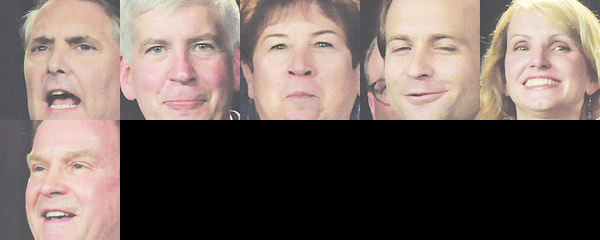

'Results found in file a-3.png'

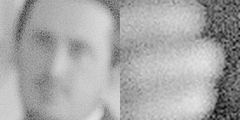

'Searching for mark'

'Results found in file a-0.png'

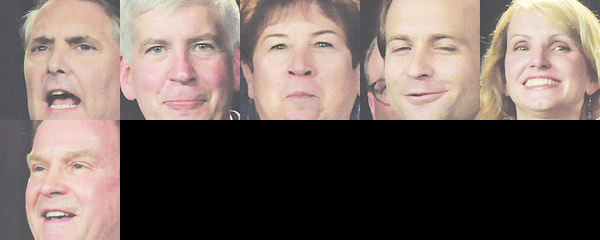

'Results found in file a-1.png'

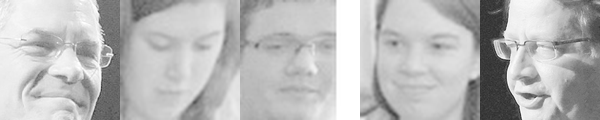

'Results found in file a-10.png'

'No faces found.'

'Results found in file a-13.png'

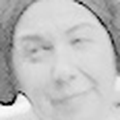

'Results found in file a-2.png'

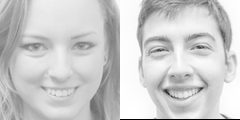

'Results found in file a-3.png'

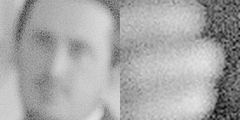

'Results found in file a-5.png'

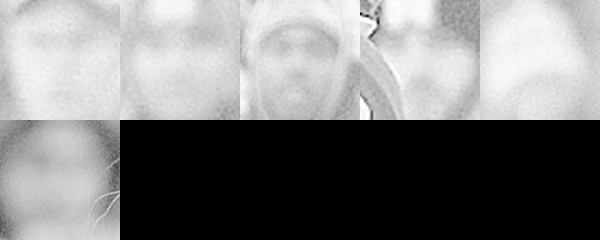

'Results found in file a-8.png'

'No faces found.'

'Results found in file a-9.png'

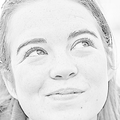

()

In [6]:
###############################################################################
# Main
###############################################################################

ShowResults("christopher")

ShowResults("mark")
